In [1]:
# if run in colab
from google.colab import drive
drive.mount('/content/drive')
cd drive/MyDrive/PubPulse
pwd
import sys
sys.path.append('/content/drive/MyDrive/PubPulse/lib')
sys.path.append('/content/drive/MyDrive/PubPulse/data')
sys.path.append('/content/drive/MyDrive/PubPulse/services')

SyntaxError: invalid syntax (625918773.py, line 4)

In [1]:
import sys
sys.path.append("..")
sys.path.append("../lib")
sys.path.append("../data")
sys.path.append("../services")
sys.path.append("../models")
import importlib
import preproc as pre
importlib.reload(pre)
import search_service as search
importlib.reload(search)
import os
import pandas as pd

/home/mezcla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# preprocess

In [2]:
dataset = pre.make_dataset_from_txt('../data/extracted-text/')

In [3]:
len(dataset)

299

In [4]:
dataset.head()

,type,title,input,data_source
0,ABSTRACT,ABSTRACT,ABSTRACT\n Medicine relies on the use of pharm...,Emerging Frontiers in Drug Delivery.txt
1,TITLE_PARAGRAPH,INTRODUCTION,Medicine relies on the use of pharmacologicall...,Emerging Frontiers in Drug Delivery.txt
2,TITLE_PARAGRAPH,DRUG DELIVERY SYSTEMS FOR CONTROLLED,RELEASE One important class of DDS is controll...,Emerging Frontiers in Drug Delivery.txt
3,TITLE_PARAGRAPH,SYSTEMIC RNA DELIVERY,RNAs can manipulate gene expression through se...,Emerging Frontiers in Drug Delivery.txt
4,TITLE_PARAGRAPH,DRUG DELIVERY SYSTEMS FOR LOCALIZED THERAPY,One potential limitation to systemic administr...,Emerging Frontiers in Drug Delivery.txt


In [5]:
combined_text = ' '.join(dataset[(dataset.data_source == 'Emerging Frontiers in Drug Delivery.txt') &\
                                  (dataset.type != 'ABSTRACT')].input.tolist())


In [6]:
pdf = pre.convert_pdf_to_txt('../data/raw-pdf/PMC8198544.pdf',
                             'sample_txt.txt')

In [7]:
paragraphs = dataset[(dataset.data_source == 'Emerging Frontiers in Drug Delivery.txt') &\
                                  (dataset.type != 'ABSTRACT')].input.tolist()
paragraphs = [paragraph for paragraph in paragraphs if len(paragraph) > 100]

In [8]:
for paragraph in paragraphs:
    print(len(paragraph))

1176
964
689
2804
748
736
2648
251


In [9]:
from transformers import AutoTokenizer
# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")

In [10]:
paragraphs_token_counts = [len(tokenizer.tokenize(text)) for text in paragraphs]

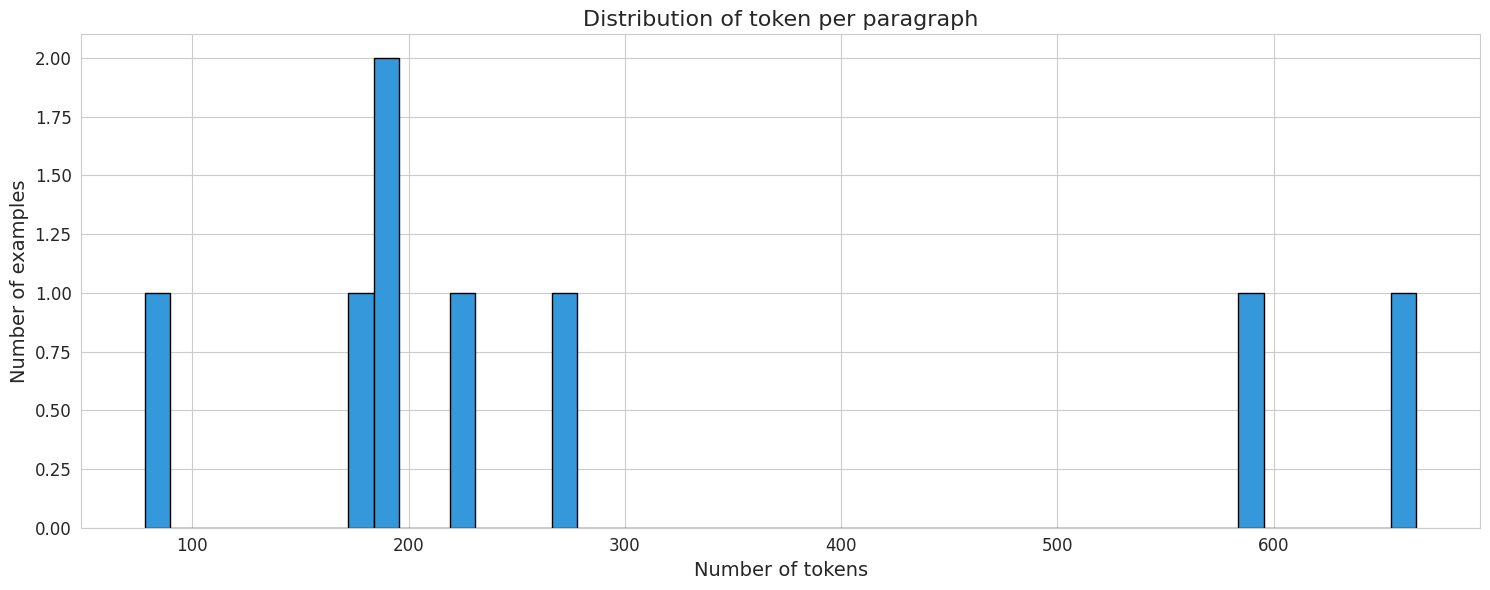

In [11]:
pre.plot_token_distribution(paragraphs_token_counts,
                            "Distribution of token per paragraph")

We must deal with the paragraphs that exceed the token limit of **512** the model `llama-2-7b.Q2_K.gguf`.

In [12]:
# Function to split and filter paragraphs
def split_and_filter_paragraphs(paragraphs, max_length=500, min_length=100):
    split_paragraphs = []
    for paragraph in paragraphs:
        # Split paragraph into chunks of approximately max_length characters
        for i in range(0, len(paragraph), max_length):
            chunk = paragraph[i:i+max_length]
            # Only add chunks that are at least min_length characters long
            if len(chunk) >= min_length:
                split_paragraphs.append(chunk)
    return split_paragraphs

# Splitting and filtering the paragraphs
processed_paragraphs = split_and_filter_paragraphs(paragraphs)

# Printing the lengths of the processed paragraphs
processed_paragraphs_lengths = [len(p) for p in processed_paragraphs]
processed_paragraphs_lengths

[500,
 500,
 176,
 500,
 464,
 500,
 189,
 500,
 500,
 500,
 500,
 500,
 304,
 500,
 248,
 500,
 236,
 500,
 500,
 500,
 500,
 500,
 148,
 251]

In [13]:
# filtered_paragraphs = [paragraph for paragraph, count in zip(split_paragraphs, split_paragraphs_token_counts) if count >= 100]

In [14]:
# for par in filtered_paragraphs:
#     print(len(par))

In [15]:
# split_paragraphs_token_counts = [len(tokenizer.tokenize(text)) for text in filtered_paragraphs]
# split_paragraphs_token_counts

# Llama-2-7b.Q2_K.gguf

In [15]:
from llama_cpp import Llama
llm = Llama(model_path="../models/llama-2-7b.Q2_K.gguf")

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../models/llama-2-7b.Q2_K.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q2_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q3_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q2_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    7:         blk.0.attn_output.weight q3_K     [  4096,  4096,     1,     1 ]
llama

In [21]:
from tqdm import tqdm  # Import tqdm

summary = []
for paragraph in tqdm(filtered_paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the individual paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # Skip paragraphs that are too long
    if len(tokens) > 512:
        continue

    # Correctly format the prompt with the current paragraph
    formatted_prompt = "Q: Create a summary of this {}. Summary: ".format(paragraph)
    
    # Generate summary
    output = llm(
        formatted_prompt,
        max_tokens=150,
        stop=["Q:", "\n"],
        echo=False
    )
    
    generated_text = output['choices'][0]['text']
    summary_index = generated_text.find("Summary:")
    summary_text = generated_text[summary_index + len("Summary:"):].strip()
    
    print(summary_text)
    print("-----------")
    
    summary.append(summary_text)

combined_summary = ' '.join(summary)
print(combined_summary)


Summarizing paragraphs:  11%|████▋                                     | 1/9 [01:42<13:41, 102.67s/it]

elivery systems (DDS) have been designed using a wide array of materials and chemical strategies. Here, we define DDS as technologies that are designed to improve the specificity of therapeutics by stabilizing them in vivo, controlling their release, and localizing their effect. Many materials have released therapeutics for prolonged periods of time and at targeted locations within the body; the properties of DDS are tailored to the physicochemical attributes of the drug and the intended route of administration (Figure).
-----------



llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =      73.10 ms /   117 runs   (    0.62 ms per token,  1600.63 tokens per second)
llama_print_timings: prompt eval time =   64469.50 ms /   283 tokens (  227.81 ms per token,     4.39 tokens per second)
llama_print_timings:        eval time =   37758.36 ms /   116 runs   (  325.50 ms per token,     3.07 tokens per second)
llama_print_timings:       total time =  102661.25 ms
Llama.generate: prefix-match hit

Summarizing paragraphs:  22%|█████████▌                                 | 2/9 [02:37<08:41, 74.55s/it]llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =       0.66 ms /     1 runs   (    0.66 ms per token,  1508.30 tokens per second)
llama_print_timings: prompt eval time =   54860.92 ms /   224 tokens (  244.91 ms per token,     4.08 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,    


-----------


Summarizing paragraphs:  33%|██████████████▎                            | 3/9 [03:24<06:11, 61.91s/it]


-----------



llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =       0.67 ms /     1 runs   (    0.67 ms per token,  1494.77 tokens per second)
llama_print_timings: prompt eval time =   46869.93 ms /   193 tokens (  242.85 ms per token,     4.12 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =   46873.92 ms
Llama.generate: prefix-match hit
Summarizing paragraphs:  44%|███████████████████                        | 4/9 [04:46<05:49, 69.94s/it]
llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =       0.66 ms /     1 runs   (    0.66 ms per token,  1512.86 tokens per second)
llama_print_timings: prompt eval time =   82226.65 ms /   342 tokens (  240.43 ms per token,     4.16 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,    


-----------


Llama.generate: prefix-match hit

Summarizing paragraphs:  56%|███████████████████████▉                   | 5/9 [06:06<04:54, 73.52s/it]llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =       0.69 ms /     1 runs   (    0.69 ms per token,  1453.49 tokens per second)
llama_print_timings: prompt eval time =   79876.43 ms /   332 tokens (  240.59 ms per token,     4.16 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =   79880.73 ms
Llama.generate: prefix-match hit



-----------


Summarizing paragraphs:  67%|████████████████████████████▋              | 6/9 [06:52<03:12, 64.11s/it]


-----------



llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =       0.91 ms /     1 runs   (    0.91 ms per token,  1101.32 tokens per second)
llama_print_timings: prompt eval time =   45816.23 ms /   185 tokens (  247.66 ms per token,     4.04 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =   45821.57 ms
Llama.generate: prefix-match hit
Summarizing paragraphs:  78%|█████████████████████████████████▍         | 7/9 [08:00<02:11, 65.53s/it]
llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =      28.55 ms /    50 runs   (    0.57 ms per token,  1751.31 tokens per second)
llama_print_timings: prompt eval time =   52303.81 ms /   198 tokens (  264.16 ms per token,     3.79 tokens per second)
llama_print_timings:        eval time =   15950.22 ms /    49 runs   (  325.51 ms per token,    

of the adult population has prediabetic hyperglycemia (PG); most PG do not progress to diabetes, which is associated with significant morbidity and premature mortality. 1
-----------


Llama.generate: prefix-match hit

llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =      60.25 ms /    86 runs   (    0.70 ms per token,  1427.48 tokens per second)
llama_print_timings: prompt eval time =   86531.95 ms /   322 tokens (  268.73 ms per token,     3.72 tokens per second)
llama_print_timings:        eval time =   32954.18 ms /    85 runs   (  387.70 ms per token,     2.58 tokens per second)
llama_print_timings:       total time =  119877.82 ms
Summarizing paragraphs:  89%|██████████████████████████████████████▏    | 8/9 [10:00<01:22, 82.84s/it]Llama.generate: prefix-match hit


future of medicine will increasingly rely on drugs that target underlying genetic pathways. 2. Emerging platforms for RNA-based therapy have the potential to treat disease at a genetic level. 3. Oral administration of biologic medicines requires advanced drug delivery systems in order to deliver therapeutics to their site of action while minimizing off-target effects.
-----------



llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =     112.55 ms /   150 runs   (    0.75 ms per token,  1332.80 tokens per second)
llama_print_timings: prompt eval time =   80824.88 ms /   274 tokens (  294.98 ms per token,     3.39 tokens per second)
llama_print_timings:        eval time =   66824.69 ms /   149 runs   (  448.49 ms per token,     2.23 tokens per second)
llama_print_timings:       total time =  148429.00 ms
Summarizing paragraphs: 100%|███████████████████████████████████████████| 9/9 [12:29<00:00, 83.24s/it]

pharmacological and genetic approaches to treating chronic disease, including the development of gene therapy medications, require an improved understanding of the interaction between drug delivery vehicles and molecular targets in the body; 2) living systems can be re-engineered to work with the body, and not against, to treat disease using the outstanding delivery mechanisms of microvesicles, pathogens, and cells (e.g., selective targeting, prolonged circulation, and immune tolerance); 3) these delivery mechanisms require the development of improved materials for the safe delivery of gene editing technologies; and 4) advanced delivery methods will likely improve as we understand how biological path
-----------
elivery systems (DDS) have been designed using a wide array of materials and chemical strategies. Here, we define DDS as technologies that are designed to improve the specificity of therapeutics by stabilizing them in vivo, controlling their release, and localizing their effect

In [23]:
from tqdm import tqdm  # Import tqdm

summary = []
for paragraph in tqdm(filtered_paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the individual paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # Skip paragraphs that are too long
    if len(tokens) > 512:
        continue

    # Simplified prompt
    formatted_prompt = "Summarize this paragraph: {}".format(paragraph)
    
    # Generate summary with a possibly increased max_tokens
    output = llm(
        formatted_prompt,
        max_tokens=200,  # Increased max_tokens
        stop=["\n"],
        echo=False
    )
    
    # Extracting summary text
    generated_text = output['choices'][0]['text'].strip()
    
    # Append only if generated_text is not empty
    if generated_text:
        summary.append(generated_text)

# Concatenating with space and ensuring each summary starts on a new line
combined_summary = ' '.join(summary)
print(combined_summary)

Summarizing paragraphs:   0%|                                                   | 0/9 [00:00<?, ?it/s]Llama.generate: prefix-match hit

Summarizing paragraphs:  11%|████▊                                      | 1/9 [01:15<10:06, 75.80s/it]llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =       2.92 ms /     4 runs   (    0.73 ms per token,  1368.46 tokens per second)
llama_print_timings: prompt eval time =   74671.63 ms /   276 tokens (  270.55 ms per token,     3.70 tokens per second)
llama_print_timings:        eval time =    1104.65 ms /     3 runs   (  368.22 ms per token,     2.72 tokens per second)
llama_print_timings:       total time =   75796.48 ms
Llama.generate: prefix-match hit

Summarizing paragraphs:  22%|█████████▌                                 | 2/9 [02:30<08:46, 75.28s/it]llama_print_timings:        load time =   64469.97 ms
llama_print_timings:      sample time =      15.94 ms /    24 runs   (    0.66 ms per token,  1506.12

1). These observations have major implications for the design and development of new drugs and the understanding of old ones. For example, a mutated form of the mRNA for beta-globin may be used to treat sickle-cell anemia. A potential strategy for improving these devices is to coat them with biodegradable DDS that control release of drugs for up to several months. This strategy has been used with some success in clinical trials and may offer significant advantages over stents alone, especially when the drug being released is a thrombolytic or antirestenosis agent. Thus, to prolong the residence time and enhance bioavailability of a drug, extended-release technology can be applied. This is an important strategy for biotherapeutics that are poorly absorbed or rapidly cleared from the bloodstream. 208 However, the harvesting, purification, and administration of these microvesicles are technically challenging for clinical applications. 209 In particular, controlling the size range and spec

In [24]:
from llama_cpp import Llama
llm_m = Llama(model_path="../models/llama-2-7b.Q2_K.gguf",
           n_ctx=1500, n_gpu_layers=-1)
from tqdm import tqdm  # Import tqdm

summary = []
for paragraph in tqdm(paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the individual paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # Skip paragraphs that are too long
    if len(tokens) > 512:
        continue

    # Simplified prompt
    formatted_prompt = "Summarize this paragraph: {}".format(paragraph)
    
    # Generate summary with a possibly increased max_tokens
    output = llm_m(
        formatted_prompt,
        max_tokens=200,  # Increased max_tokens
        stop=["\n"],
        echo=False
    )
    
    # Extracting summary text
    generated_text = output['choices'][0]['text'].strip()
    
    # Append only if generated_text is not empty
    if generated_text:
        summary.append(generated_text)

# Concatenating with space and ensuring each summary starts on a new line
combined_summary = ' '.join(summary)
print(combined_summary)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../models/llama-2-7b.Q2_K.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q2_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q3_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q2_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    7:         blk.0.attn_output.weight q3_K     [  4096,  4096,     1,     1 ]
llama

1). In other words, DDS are custom-built to ensure that each drug is delivered in a therapeutic effective dose at a targeted site where it will exert its effect. The next section provides an overview of these concepts. For example, the islet beta-cells in type I diabetics have been replaced with insulin-producing cells derived from stem cells through microvesicle isolation and purification for autologous therapy (Figure The remaining authors have declared no interests with commercial supporters.




llama_print_timings:        load time =  101523.53 ms
llama_print_timings:      sample time =       8.49 ms /    14 runs   (    0.61 ms per token,  1649.78 tokens per second)
llama_print_timings: prompt eval time =   20975.83 ms /    78 tokens (  268.92 ms per token,     3.72 tokens per second)
llama_print_timings:        eval time =    4588.45 ms /    13 runs   (  352.96 ms per token,     2.83 tokens per second)
llama_print_timings:       total time =   25622.28 ms


In [28]:
len(combined_text)

10062

In [16]:
from llama_cpp import Llama
llm_l = Llama(model_path="../models/llama-2-7b.Q2_K.gguf",
              n_ctx=500, n_gpu_layers=-1)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../models/llama-2-7b.Q2_K.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q2_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q3_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q2_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    7:         blk.0.attn_output.weight q3_K     [  4096,  4096,     1,     1 ]
llama

In [17]:
from transformers import AutoTokenizer
# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")
tokens_combined_text = tokenizer.tokenize(pdf)

In [19]:

from tqdm import tqdm  # Import tqdm

summary = []
for paragraph in tqdm(processed_paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the individual paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # # Skip paragraphs that are too long
    # if len(tokens) > 512:
    #     continue

    # Simplified prompt
    formatted_prompt = "Summarize this paragraph: {}".format(paragraph)
    
    # Generate summary with a possibly increased max_tokens
    output = llm_l(
        formatted_prompt,
        max_tokens=150,  # Increased max_tokens
        stop=["\n"],
        echo=False
    )
    
    # Extracting summary text
    generated_text = output['choices'][0]['text'].strip()
    
    # Append only if generated_text is not empty
    if generated_text:
        summary.append(generated_text)

# Concatenating with space and ensuring each summary starts on a new line
combined_summary = ' '.join(summary)
print(combined_summary)

Summarizing paragraphs:   4%|█▊                                        | 1/24 [00:31<12:00, 31.33s/it]
llama_print_timings:        load time =   31314.65 ms
llama_print_timings:      sample time =       0.65 ms /     1 runs   (    0.65 ms per token,  1529.05 tokens per second)
llama_print_timings: prompt eval time =   31312.92 ms /   134 tokens (  233.68 ms per token,     4.28 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =   31318.26 ms
Llama.generate: prefix-match hit
Summarizing paragraphs:   8%|███▌                                      | 2/24 [01:23<15:55, 43.41s/it]
llama_print_timings:        load time =   31314.65 ms
llama_print_timings:      sample time =      63.01 ms /    99 runs   (    0.64 ms per token,  1571.30 tokens per second)
llama_print_timings: prompt eval time =   23624.82 ms /   109 tokens (  216.74 ms per token,     4.61 tokens per se

issue-specific time. In addition, many approaches have been applied to limit the release of drugs to a particular environment or location. These strategies include the use of biodegradable polymers and liposomes that are able to degrade in situ at desired rates. The chemical strategy can also be used to control the rate of drug release in vivo by altering physicochemical properties, such as pH, osmolality, and viscosity. 2. савез 6.4). DDS can be classified by their release mechanism, which involves either passive diffusion into the bloodstream or active transport across a biological membrane, such as a cellular wall, using transporters that are specific to a particular molecule (13). ues to design controlled release systems. These cues include the shape of the drug, its physicochemical properties, and the release rate required by the targeted application. For example, oral drug delivery systems may interact with enzymes in the GI tract before reaching their target organ, which is impo

In [20]:
combined_summary

'issue-specific time. In addition, many approaches have been applied to limit the release of drugs to a particular environment or location. These strategies include the use of biodegradable polymers and liposomes that are able to degrade in situ at desired rates. The chemical strategy can also be used to control the rate of drug release in vivo by altering physicochemical properties, such as pH, osmolality, and viscosity. 2. савез 6.4). DDS can be classified by their release mechanism, which involves either passive diffusion into the bloodstream or active transport across a biological membrane, such as a cellular wall, using transporters that are specific to a particular molecule (13). ues to design controlled release systems. These cues include the shape of the drug, its physicochemical properties, and the release rate required by the targeted application. For example, oral drug delivery systems may interact with enzymes in the GI tract before reaching their target organ, which is imp

In [ ]:
from tqdm import tqdm  # Import tqdm
from llama_cpp import Llama

llm = Llama(model_path="../models/llama-2-7b.Q2_K.gguf")
summary = []
for paragraph in tqdm(paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # Skip paragraphs that are too long
    if len(tokens) > 512:
        continue

    # Format the prompt with the individual paragraph
    formatted_prompt = """Summarize the following text, include only full sentences, 
                           don't include stuff like Table, Figure, 
                           create fluent text that can be merged with other snippets: {}\nSummary:""".format(paragraph)

    # formatted_prompt = """Summarize the following text, include only full sentences, 
    #                        don't include stuff like Table, Figure, 
    #                        create fluent text that can be merged with other snippets: {}\nSummary:""".format(paragraph)
    
    # Generate summary
    output = llm(
        formatted_prompt,
        max_tokens=200,
        stop=["\n"]
    )
    
    generated_text = output['choices'][0]['text']
    summary_index = generated_text.find("Summary:")
    summary_text = generated_text[summary_index + len("Summary:"):].strip()
    
    print(summary_text)
    print("-----------")
    
    summary.append(summary_text)

combined_summary = ' '.join(summary)
print(combined_summary)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../models/llama-2-7b.Q2_K.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q2_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q3_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q3_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q2_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    7:         blk.0.attn_output.weight q3_K     [  4096,  4096,     1,     1 ]
llama

In [52]:
combined_summary

' xt above is summarized by the following sentence fragments:  ent routes of administration, such as injection and oral ingestion, have different challenges when administering drugs to patients. Nordisk has developed a new drug delivery system (DDS) that overcomes many obstacles associated with delivering biologic therapeutics. ically based drug delivery systems (DDS) are gaining interest as a means for the targeted administration of therapeutics, including vaccines, to treat disease states,  such as diabetes mellitus and heart failure (HF).  DDS have been shown to be effective in eliciting an immune response after injection into the peritoneum.  These approaches are generally safer than conventional therapies with fewer side effects or complications when compared with traditional therapies, such as chemotherapy and insulin injections for diabetes mellitus patients. '

In [50]:
from tqdm import tqdm  # Import tqdm

summary = []
for paragraph in tqdm(paragraphs, desc="Summarizing paragraphs"):
    print(len(paragraph))
    formatted_prompt = """Summarize the following text, include only full sentences, 
                           don't include stuff like Table, Figure, 
                           create fluent text that can be merged with other snippets: {}\nSummary:""".format(paragraphs)
    
    output = llm(
        formatted_prompt,
        max_tokens=150,
        stop=["\n"]
    )
    
    generated_text = output['choices'][0]['text']
    summary_index = generated_text.find("Summary:")
    summary_text = generated_text[summary_index + len("Summary:"):].strip()
    
    print(summary_text)
    print("-----------")
    
    summary.append(summary_text)

combined_summary = ' '.join(summary)
print(combined_summary)


Summarizing paragraphs:   0%|                                                   | 0/8 [00:00<?, ?it/s]

1176


ValueError: Requested tokens (2450) exceed context window of 512

In [37]:
# Format the prompt with the text to summarize
formatted_prompt = "Summarize the following text: {}\nSummary:".format(paragraphs[0])

# Call the language model with the formatted prompt
output = llm(
    formatted_prompt,
    max_tokens=200,
    stop=["Q:", "\n"],
    echo=True
)

# Get the generated text from the output
generated_text = output['choices'][0]['text']

# Find the position of "Summary:" in the text
summary_index = generated_text.find("Summary:")

# Extract everything after "Summary:"
summary_text = generated_text[summary_index + len("Summary:"):].strip()

# Print the extracted summary
print(summary_text)

Llama.generate: prefix-match hit


1.1). Drug delivery technologies can be classified into three primary categories depending on their physical form during administration: solid, liquid, or gas. Solid-form systems include implants, depots, particles, and capsules. Liquid-form devices contain a controlled-release suspension (CRS) or liposomes. Finally, gas-form technologies rely on propulsion mechanisms such as compressed gases (e.g., CO2), pressurized fluids, or surface tension–based techniques to transport and deliver drugs in vivo.



llama_print_timings:        load time =    3448.41 ms
llama_print_timings:      sample time =      77.74 ms /   125 runs   (    0.62 ms per token,  1607.94 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   38708.79 ms /   125 runs   (  309.67 ms per token,     3.23 tokens per second)
llama_print_timings:       total time =   39198.73 ms


In [34]:
output['choices'][0]['text']

'Summarize the following text: Medicine relies on the use of pharmacologically active agents (therapeutics or drugs) to manage or reverse the course of disease. The current global pharmaceutical market is valued at $980 billion annually, and, in the U.S., nearly 50% of the population has used at least one prescription medication in the past 30 days. \nIn the ideal case, drugs would be applied in vivo at exactly the therapeutic concentration and would precisely target cells that cause disease. However, drug delivery is not easily controlled. Drug release rates, cell-and tissue-specific targeting, and drug stability are difficult to predict. To address these limitations, drug delivery systems (DDS) have been designed using a wide array of materials and chemical strategies. Here, we define DDS as technologies that are designed to improve the specificity of therapeutics by stabilizing them in vivo, controlling their release, and localizing their effect. Many materials have released therape

In [22]:
# Format the prompt with the text to summarize
formatted_prompt = "Summarize the following text: {}\nSummary:".format(paragraphs[0])

# Call the language model with the formatted prompt
output = llm(
    formatted_prompt,
    max_tokens=500,
    stop=["Q:", "\n"],
    echo=True
)

# Print the output
print(output)


Llama.generate: prefix-match hit


{'id': 'cmpl-3464f2b1-a673-4d55-9a81-9382fda885bb', 'object': 'text_completion', 'created': 1701342357, 'model': '../models/llama-2-7b.Q2_K.gguf', 'choices': [{'text': 'Summarize the following text: Medicine relies on the use of pharmacologically active agents (therapeutics or drugs) to manage or reverse the course of disease. The current global pharmaceutical market is valued at $980 billion annually, and, in the U.S., nearly 50% of the population has used at least one prescription medication in the past 30 days. \nIn the ideal case, drugs would be applied in vivo at exactly the therapeutic concentration and would precisely target cells that cause disease. However, drug delivery is not easily controlled. Drug release rates, cell-and tissue-specific targeting, and drug stability are difficult to predict. To address these limitations, drug delivery systems (DDS) have been designed using a wide array of materials and chemical strategies. Here, we define DDS as technologies that are desig


llama_print_timings:        load time =    3448.41 ms
llama_print_timings:      sample time =      64.93 ms /   105 runs   (    0.62 ms per token,  1617.13 tokens per second)
llama_print_timings: prompt eval time =   85886.35 ms /   280 tokens (  306.74 ms per token,     3.26 tokens per second)
llama_print_timings:        eval time =   40193.95 ms /   104 runs   (  386.48 ms per token,     2.59 tokens per second)
llama_print_timings:       total time =  126543.56 ms


In [35]:
formatted_prompt = "Summarize the following text: {}\nSummary:".format(paragraphs[0])

output = llm(
    formatted_prompt,
    max_tokens=200,  # Increased max_tokens
    stop=["\n"],     # Adjusted stop token
    echo=False       # Turn off echo
)

# Extract the generated text from the output
generated_text = output['choices'][0]['text']

# Print the generated text (which should be the summary)
print(generated_text)


Llama.generate: prefix-match hit


 Drug delivery systems (DDS) are designed to control the release rate and specificity of pharmacologically active agents (drugs). DDS may be formulated as suspensions, gels, or particles. The targeted site for drug delivery is often defined by chemical attributes of the therapeutic agent itself. 



llama_print_timings:        load time =    3448.41 ms
llama_print_timings:      sample time =      43.36 ms /    71 runs   (    0.61 ms per token,  1637.45 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   23284.97 ms /    71 runs   (  327.96 ms per token,     3.05 tokens per second)
llama_print_timings:       total time =   23568.61 ms


In [ ]:
## 

In [ ]:
def generate_summary(text_chunk):
    # Defining the template to generate summary
    template = """
    Write a concise summary of the text, return your responses with 10 lines that cover the key points of the text.
    ```{text}```
    SUMMARY:
    """
    prompt = PromptTemplate(template=template, 
                            input_variables=["text"])
    llm_chain = LLMChain(prompt=prompt, llm=LLM)

    summary = llm_chain.run(text_chunk)
    return summary

# llama-2-7b-chat.ggmlv3.q8_0

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Path to your local model directory
local_model_directory = "../models/llama-2-7b-chat.ggmlv3.q8_0"  # Adjust this path

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(local_model_directory)

# Load the model
model = AutoModelForCausalLM.from_pretrained(local_model_directory)

In [ ]:
# Run text generation pipeline
prompt = f"Summarize this: {}".format(combined_text)
instruction = f"### Instruction:\n{prompt}\n\n### Summary:\n"
pipe = pipeline(task="summarization", # "text-generation" 
                model=model, 
                tokenizer=tokenizer, 
                max_length=200)
result = pipe(instruction)
print(result[0]['generated_text'][len(instruction):])

In [1]:
# from llama_cpp import Llama

In [25]:
# LLM = Llama(model_path="../models/llama-2-7b-chat.ggmlv3.q8_0.bin")

In [ ]:
# # Load model directly
# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("austinm2151/Llama2-7b-Summarizer")
# model = AutoModelForCausalLM.from_pretrained("austinm2151/Llama2-7b-Summarizer")

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

# NousResearch/Llama-2-7b-hf

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")
model = AutoModelForCausalLM.from_pretrained("NousResearch/Llama-2-7b-hf")

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

In [ ]:
from transformers import pipeline

# Run text generation pipeline
prompt = f"Summarize this: {combined_text}"
instruction = f"### Instruction:\n{prompt}\n\n### Summary:\n"

pipe = pipeline(task="summarization", # "text-generation" 
                model=model, 
                tokenizer=tokenizer, 
                max_length=128)
result = pipe(instruction)
print(result[0]['generated_text'][len(instruction):])

In [8]:
dataset.head()

,type,title,input,data_source
0,ABSTRACT,ABSTRACT,ABSTRACT\n Medicine relies on the use of pharm...,Emerging Frontiers in Drug Delivery.txt
1,TITLE_PARAGRAPH,INTRODUCTION,Medicine relies on the use of pharmacologicall...,Emerging Frontiers in Drug Delivery.txt
2,TITLE_PARAGRAPH,DRUG DELIVERY SYSTEMS FOR CONTROLLED,RELEASE One important class of DDS is controll...,Emerging Frontiers in Drug Delivery.txt
3,TITLE_PARAGRAPH,SYSTEMIC RNA DELIVERY,RNAs can manipulate gene expression through se...,Emerging Frontiers in Drug Delivery.txt
4,TITLE_PARAGRAPH,DRUG DELIVERY SYSTEMS FOR LOCALIZED THERAPY,One potential limitation to systemic administr...,Emerging Frontiers in Drug Delivery.txt


# Llama2 Summarizer

In [16]:
# pdf

In [17]:
# from transformers import AutoModelForCausalLM, AutoTokenizer
# import torch

# # Path to your model directory
# model_directory = "../models/Llama2-7b-Summarizer" 


# # Load the tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_directory)

# # Load the model
# model = AutoModelForCausalLM.from_pretrained(model_directory)

# # Prepare your input text
# input_text = combined_text
# input_ids = tokenizer.encode(pdf, 
#                              return_tensors='pt')

# # Set the desired maximum length for the generated text
# max_length = 200

# # Generate output
# output = model.generate(input_ids, max_length=max_length)

# # Decode the output to text
# decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

# print(decoded_output)


In [20]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Path to your model directory
model_directory = "../models/Llama2-7b-Summarizer" 

def summarize(input_text, model_directory):
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_directory)
    
    # Load the model
    model = AutoModelForCausalLM.from_pretrained(model_directory)
    
    # Prepare your input text
    input_text = input_text
    input_ids = tokenizer.encode(pdf, 
                                 return_tensors='pt')
    
    # Set the desired maximum length for the generated text
    max_length = 200
    
    # Generate output
    output = model.generate(input_ids, max_length=max_length)
    
    # Decode the output to text
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
    print(decoded_output)

    return decoded_output


In [21]:
len(split_paragraphs_token_counts)

9

In [28]:
for paragraph in paragraphs:
    print(len(paragraph))

1176
964
689
2804
748
736
2648
251


In [30]:
for paragraph in processed_paragraphs:
    print(len(paragraph))

500
500
176
500
464
500
189
500
500
500
500
500
304
500
248
500
236
500
500
500
500
500
148
251


In [ ]:
from tqdm import tqdm  # Import tqdm
model_directory = "../models/Llama2-7b-Summarizer" 

summary = []
for paragraph in tqdm(processed_paragraphs, desc="Summarizing paragraphs"):
    generated_text = summarize(paragraph, model_directory)
    # Append only if generated_text is not empty
    if generated_text:
        summary.append(generated_text)
# Concatenating with space and ensuring each summary starts on a new line
combined_summary = ' '.join(summary)
print(combined_summary)

Summarizing paragraphs:   0%|                                                  | 0/24 [00:00<?, ?it/s]

In [ ]:

from tqdm import tqdm  # Import tqdm

summary = []
for paragraph in tqdm(paragraphs, desc="Summarizing paragraphs"):
    # Tokenize the individual paragraph to check its length
    tokens = tokenizer.tokenize(paragraph)
    
    # # Skip paragraphs that are too long
    # if len(tokens) > 512:
    #     continue

    # Simplified prompt
    formatted_prompt = "Summarize this paragraph: {}".format(paragraph)
    
    # Generate summary with a possibly increased max_tokens
    output = llm_l(
        formatted_prompt,
        max_tokens=100,  # Increased max_tokens
        stop=["\n"],
        echo=False
    )
    
    # Extracting summary text
    generated_text = output['choices'][0]['text'].strip()
    
    # Append only if generated_text is not empty
    if generated_text:
        summary.append(generated_text)

# Concatenating with space and ensuring each summary starts on a new line
combined_summary = ' '.join(summary)
print(combined_summary)